In [88]:
import warnings
from datetime import datetime, timedelta
from datetime import date
from pandas import Series
import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import recall_score, precision_score, f1_score, log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score

import matplotlib
plt.style.use('seaborn')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8, 5)

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

warnings.filterwarnings("ignore")

In [89]:
RANDOM_SEED = 42

In [90]:
#file_path = '/kaggle/input/sf-dst-scoring/'
file_path = 'sf-dst-scoring/'
train = pd.read_csv(file_path + 'train.csv')
test = pd.read_csv(file_path + 'test.csv')
sample_submission = pd.read_csv(file_path + 'sample_submission.csv')

### Описания полей

`client_id` - идентификатор клиента

`education` - уровень образования

`sex` - пол заемщика

`age` - возраст заемщика

`car` - флаг наличия автомобиля

`car_type` - флаг автомобиля иномарки

`decline_app_cnt` - количество отказанных прошлых заявок

`good_work` - флаг наличия “хорошей” работы

`bki_request_cnt` - количество запросов в БКИ

`home_address` - категоризатор домашнего адреса

`work_address` - категоризатор рабочего адреса

`income` - доход заемщика

`foreign_passport` - наличие загранпаспорта

`sna` - связь заемщика с клиентами банка

`first_time` - давность наличия информации о заемщике

`score_bki` - скоринговый балл по данным из БКИ

`region_rating` - рейтинг региона

`app_date` - дата подачи заявки

`default` - флаг дефолта по кредиту

#### Анализ данных, проверка наличия пропусков

In [91]:
train.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
72705,100777,17APR2014,NaN,F,58,N,N,0,0,-2.267773,3,50,2,3,10000,4,1,N,0
32015,44409,20FEB2014,GRD,F,66,N,N,0,0,-1.147723,3,50,2,3,8300,1,3,N,0
20646,55051,04MAR2014,SCH,M,44,Y,Y,0,0,-1.567415,0,60,3,3,50000,1,1,N,0
57067,51143,27FEB2014,GRD,M,32,Y,Y,0,0,-1.337986,0,50,1,1,30000,1,3,N,0
69339,55351,04MAR2014,UGR,F,32,N,N,5,0,-1.438649,12,40,2,3,40000,1,2,N,0


In [92]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [93]:
train.isnull().sum()

client_id             0
app_date              0
education           307
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
default               0
dtype: int64

In [94]:
test.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
20267,13248,20JAN2014,GRD,M,31,N,N,0,0,-2.718912,0,60,1,2,15000,1,2,N
2286,41448,18FEB2014,GRD,F,26,N,N,1,0,-1.510148,0,60,1,2,30000,1,3,N
30813,8090,15JAN2014,SCH,M,34,N,N,0,0,-1.251214,0,40,2,3,25000,1,2,N
23370,78224,26MAR2014,GRD,F,23,Y,Y,0,0,-2.052564,3,60,2,3,30000,1,3,Y
3851,90603,07APR2014,SCH,F,25,N,N,3,0,-1.857687,4,80,2,3,40000,1,3,N


In [95]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [96]:
test.isnull().sum()

client_id             0
app_date              0
education           171
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
dtype: int64

In [97]:
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income', 'days']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['education', 'home_address', 'work_address',
            'sna', 'first_time', 'region_rating']

#### Посмотрим на распределение уровня образования

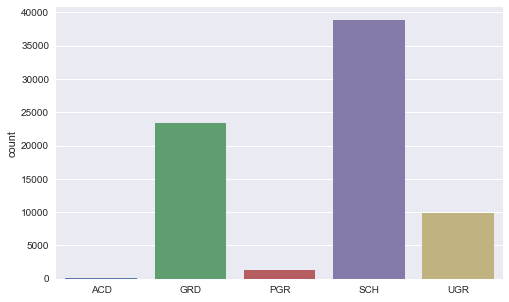

In [98]:
sns.countplot(sorted(train['education'].dropna()))
plt.show()

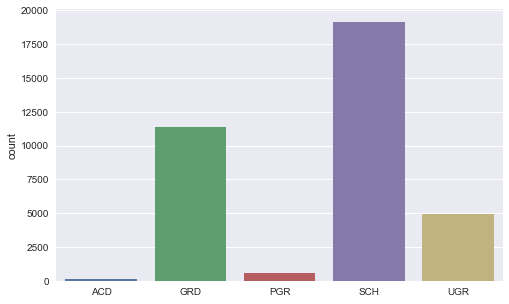

In [99]:
sns.countplot(sorted(test['education'].dropna()))
plt.show()

Большинство имеют SCH, заполним пропуски самым часто встречающимся значением

In [100]:
# Заполняем значения NaN

train.fillna(train['education'].mode()[0], inplace=True)
test.fillna(test['education'].mode()[0], inplace=True)

In [101]:
# Посмотрим сколько уникальных значений имеет признак education
train.education.unique()

array(['SCH', 'GRD', 'UGR', 'PGR', 'ACD'], dtype=object)

In [102]:
# Объединим значения признака 'UGR','PGR','ACD'

In [103]:
def code_ed(s):
    if s == "SCH":
        return 1
    elif s == "GRD":
        return 2
    elif s == 'UGR':
        return 3
    elif s == 'PGR':
        return 3
    else:
        return 3    

In [104]:
train['education'] = train['education'].apply(code_ed)
test['education'] = test['education'].apply(code_ed)

In [105]:
# Посмотрим на распределение decline_app_cnt

train.decline_app_cnt.value_counts()

0     61214
1      8397
2      2468
3       903
4       414
5       165
6       113
7        48
9        24
8        19
10       11
11        9
13        3
12        2
14        2
16        2
24        1
15        1
19        1
22        1
33        1
Name: decline_app_cnt, dtype: int64

Большую часть значений принимает 0, когда отказов раньше не было

In [106]:
# делаем признак категориальным
# все значения прошлых отказов более 4 приравниваем к 4

train.decline_app_cnt = train.decline_app_cnt.apply(lambda x: x if x < 4 else 4)
test.decline_app_cnt = test.decline_app_cnt.apply(lambda x: x if x < 4 else 4)

In [107]:
# внесем изменения в списки

num_cols.remove('decline_app_cnt')
cat_cols.append('decline_app_cnt')

In [108]:
# Посмотрим на распределение bki_request_cnt

train.bki_request_cnt.value_counts()

0     19381
1     18276
2     13749
3      9187
4      5627
5      3268
6      1704
7       852
8       508
9       299
10      225
11      188
12      144
13       94
14       86
15       54
16       35
18       22
17       19
19       18
21       12
24       11
20        9
23        7
28        4
22        4
32        2
27        2
26        2
25        2
46        1
29        1
33        1
34        1
36        1
41        1
45        1
53        1
Name: bki_request_cnt, dtype: int64

Большинство запросов равно от 0 до 4

In [109]:
# делаем признак категориальным
# все значения запросов свыше 6 приравниваем к 6

train.bki_request_cnt = train.bki_request_cnt.apply(lambda x: x if x < 6 else 6)
test.bki_request_cnt  = test.bki_request_cnt.apply(lambda x: x if x < 6 else 6)

In [110]:
# внесем изменения в списки

num_cols.remove('bki_request_cnt')
cat_cols.append('bki_request_cnt')

### Изучим параметр app_date

In [111]:
train.app_date.head()

0    01FEB2014
1    12MAR2014
2    01FEB2014
3    23JAN2014
4    18APR2014
Name: app_date, dtype: object

#### Преобразование к формату datatime, создание нового признака на его основе days - количество дней с момента подачи заявки

In [112]:
train['app_date'] = train['app_date'].apply(lambda x: datetime.strptime(x, '%d%b%Y'))
test['app_date'] = test['app_date'].apply(lambda x: datetime.strptime(x, '%d%b%Y'))

In [113]:
# Количество дней, прошедших со дня подачи заявки
train['days'] = (datetime.now() - train.app_date).dt.days
test['days']  = (datetime.now() - test.app_date).dt.days

#### Создадим новый числовой признак на базе признаков дохода и рейтинга региона

In [114]:
_mode_rating = float(train['region_rating'].append(test['region_rating']).mode())
_mean_age = train['age'].append(test['age']).mean()

train['age_income'] = train['income'] * train['age'] * _mode_rating / (train['region_rating']*_mean_age)
test['age_income'] = test['income'] * train['age'] * _mode_rating / (test['region_rating']*_mean_age)

num_cols.append('age_income')

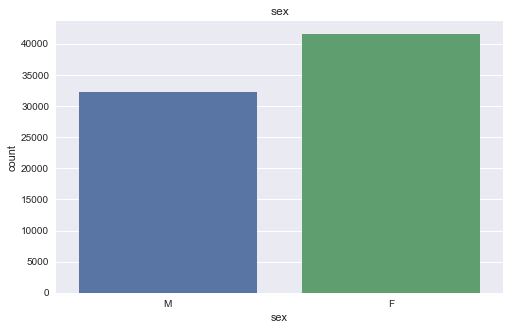

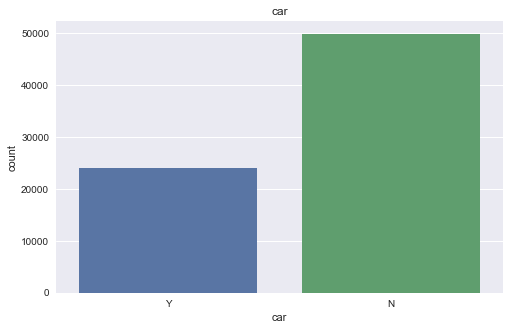

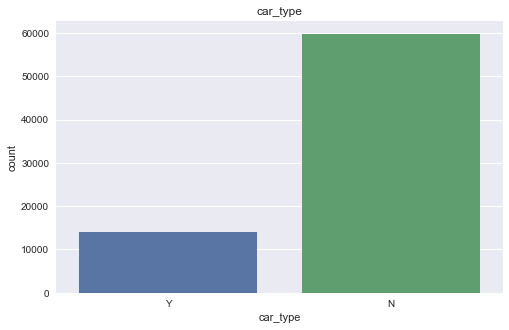

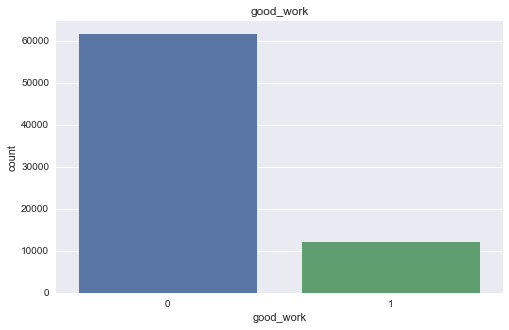

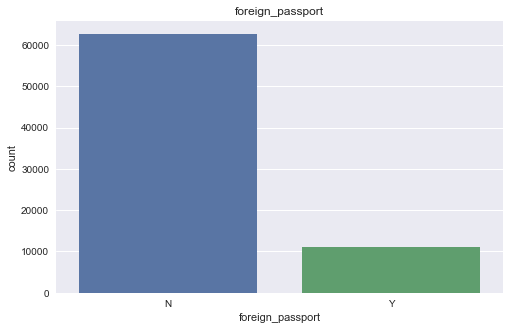

In [115]:
# Посмотрим на гистограммы распределения бинарных признаков

for col in bin_cols:
    plt.figure()
    sns.countplot(train[col])
    plt.title(col)
    plt.show()

Чтобы алгоритмы машинного обучения могли работать с категориальными данными, их нужно преобразовать в числа.

In [116]:
le = LabelEncoder()

for col in bin_cols:
    train[col] = le.fit_transform(train[col])
    test[col]  = le.transform(test[col])

In [117]:
# Еще пробую добавить новые признаки, которые должны будут улучшить результаты модели

train['bki_age_reg'] = (train['score_bki']/train['age'])*train['region_rating']
test['bki_age_reg'] = (test['score_bki']/test['age'])*test['region_rating']

train['mult_sna_ftime'] = train['sna'] * train['first_time']
test['mult_sna_ftime'] = test['sna'] * test['first_time']

train['edu_and_income'] = (train['education'] + 1) * train['income']
test['edu_and_income'] = (test['education'] + 1) * test['income']

train['success_client'] = (train['foreign_passport'] + 1) * (train['good_work'] + 1) * (train['car'] + 1)
test['success_client'] = (test['foreign_passport'] + 1) * (test['good_work'] + 1) * (test['car'] + 1)

train['very_success_client'] = train['foreign_passport'] * train['good_work'] * train['car']
test['very_success_client'] = test['foreign_passport'] * test['good_work'] * test['car']

train['fpassp_and_gwork'] = train['foreign_passport'] * train['good_work'] 
test['fpassp_and_gwork'] = test['foreign_passport'] * test['good_work']

train['fpassp_and_car'] = train['foreign_passport'] * train['car']
test['fpassp_and_car'] = test['foreign_passport'] * test['car']

train['gwork_and_car'] = train['good_work'] * train['car']
test['gwork_and_car'] = test['good_work'] * test['car']

In [118]:
# Добавляем новые признаки в соответствующие списки

num_cols.append('bki_age_reg')
num_cols.append('edu_and_income')

cat_cols.append('success_client')
cat_cols.append('mult_sna_ftime')

bin_cols.append('very_success_client')
bin_cols.append('fpassp_and_gwork')
bin_cols.append('fpassp_and_car')
bin_cols.append('gwork_and_car')

#### Посмотрим на распределение числовых данных:

In [119]:
def no_outliers(values):
    q_25, q_75 = np.percentile(values, [25, 75])
    return q_25 - (q_75 - q_25)*1.5, q_75 + (q_75 - q_25)*1.5

#### Построим boxplots для численных переменных

In [120]:
# Функция построения boxplot по признакам

def get_boxplot(col):
    _l, _h = no_outliers(train[col])
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.grid()
    sns.boxplot(x='default', y=col, data=train[train[col].between(_l, _h)], ax=ax)
    plt.xticks(rotation=0)
    ax.set_title('Boxplot for ' + col)
    plt.show()

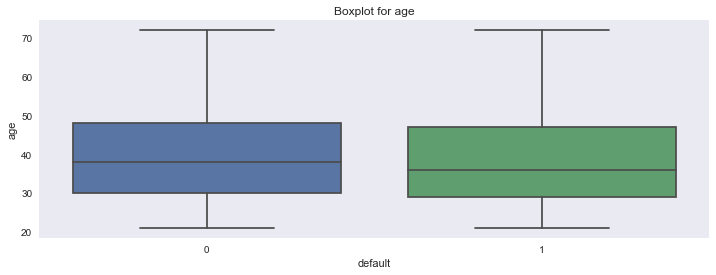

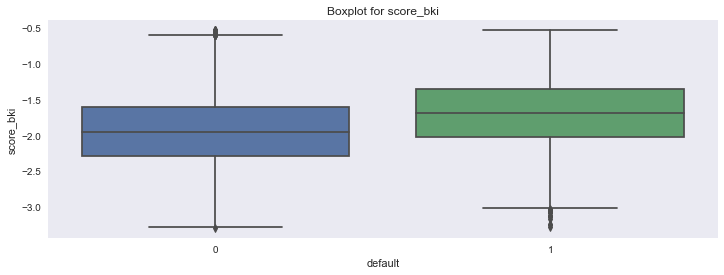

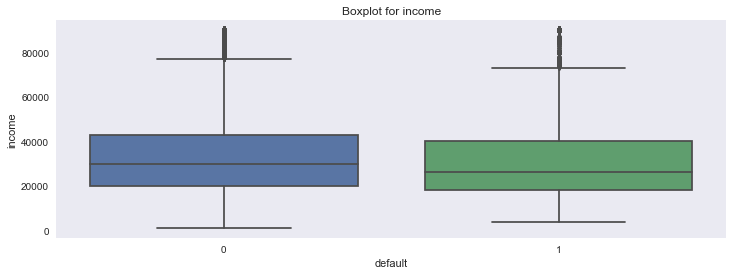

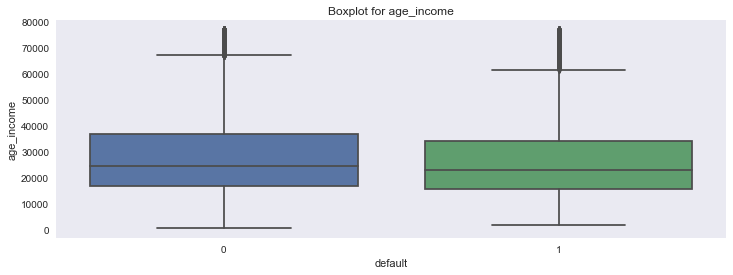

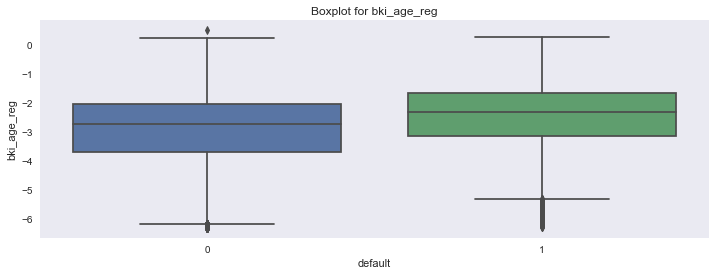

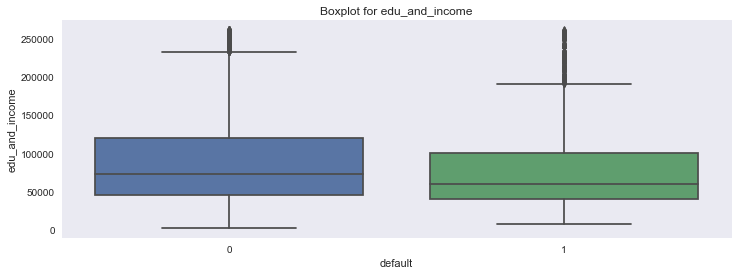

In [121]:
for col in num_cols:
    if col in ['days']:
        continue
    get_boxplot(col)

*Дефолтные клиенты в среднем младше*

*Дефолтные клиенты в среднем имеют большое количество отмененных заявок*

*Дефолтные клиенты в среднем имеют больше запросов в БКИ*

*Дефолтные клиенты в среднем имеют более высокую оценку в БКИ*

*Дефолтные клиенты в среднем имеют более низкий доход*

#### Найдем и устраним выбросы в числовых переменных методом межквартильного расстояния 

In [122]:
for col in num_cols:
    if col in ['days']:
        continue
    _l, _h = no_outliers(train[col])
    train = train.loc[train[col].between(_l, _h)]

#### Построим диаграмму для переменной default, чтобы узнать каких клиентов у банка больше

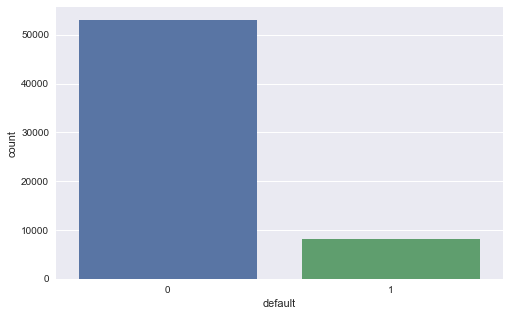

In [123]:
sns.countplot(x='default', data=train)
plt.show()

In [124]:
# Очевидно что выборка распределена неравномерно и недефолтных клиентов намного больше
# Используем oversampling для устранения дисбаланса

train_0 = train.query('default == 0')
train_1 = train.query('default == 1')
for i in range(int(len(train_0)/len(train_1))):
    train = train.append(train_1).reset_index(drop=True) # объединяем

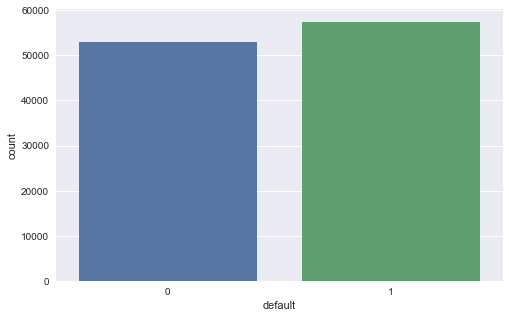

In [125]:
sns.countplot(x='default', data=train)
plt.show()

In [126]:
train['mult_sna_ftime'].value_counts()

4     38499
3     31707
2     12350
6      9883
12     6105
8      4326
1      4098
9      2375
16     1110
Name: mult_sna_ftime, dtype: int64

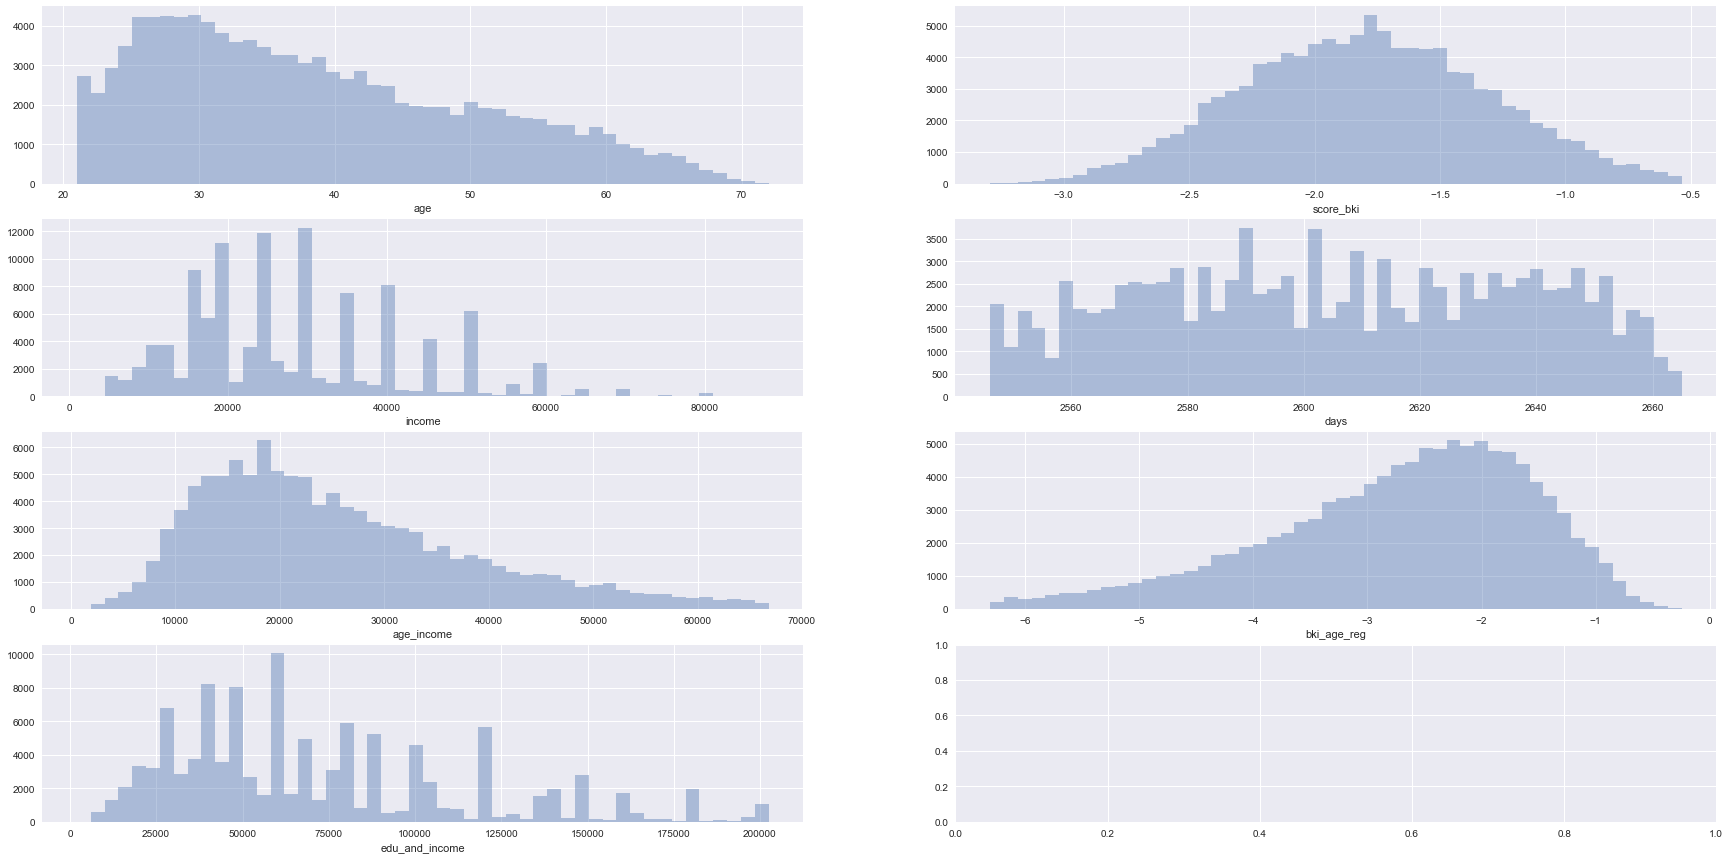

In [127]:
fig, axes = plt.subplots(math.ceil(len(num_cols)/2), 2, figsize=(30,15))
for col, i in zip(num_cols, range(len(num_cols))):
    sns.distplot(train[col], kde = False, ax=axes.flat[i])

#### Логарифмируем переменные, распределение которых смещено

In [128]:
for col in num_cols:
    if col in ['score_bki','bki_age_reg']:
        continue
    train[col] = np.log(train[col] + 1)
    test[col] = np.log(test[col] + 1)

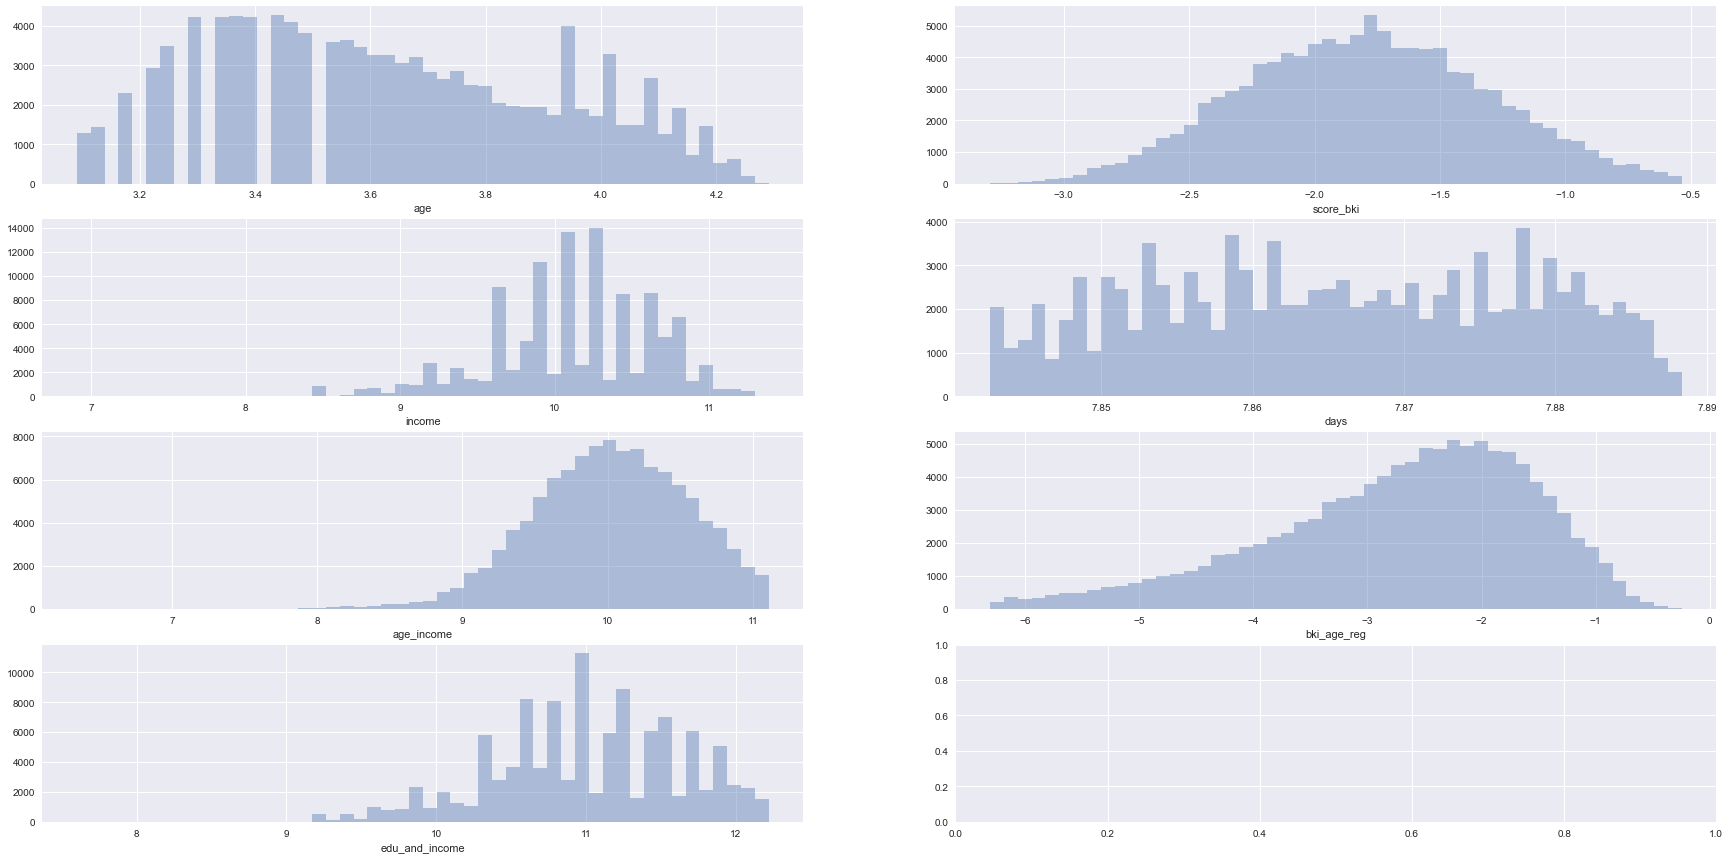

In [130]:
fig, axes = plt.subplots(math.ceil(len(num_cols)/2), 2, figsize=(30,15))
for col, i in zip(num_cols, range(len(num_cols))):
    sns.distplot(train[col], kde = False, ax=axes.flat[i])

### Значимость непрерывных переменных
Для оценки значимости числовых переменных будем использовать функцию f_classif из библиотеки sklearn.

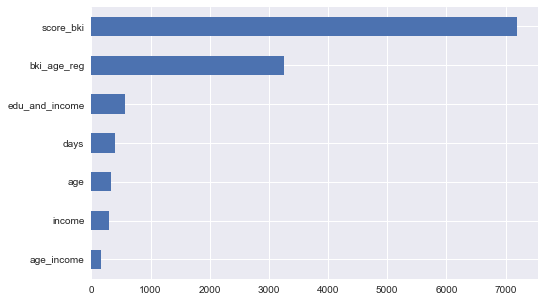

In [131]:
imp_num = Series(f_classif(train[num_cols], train['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')
plt.show()

*Наиболее значимым представляется признак score_bki*

#### Построим диаграмму корреляцонной функции Пирсона

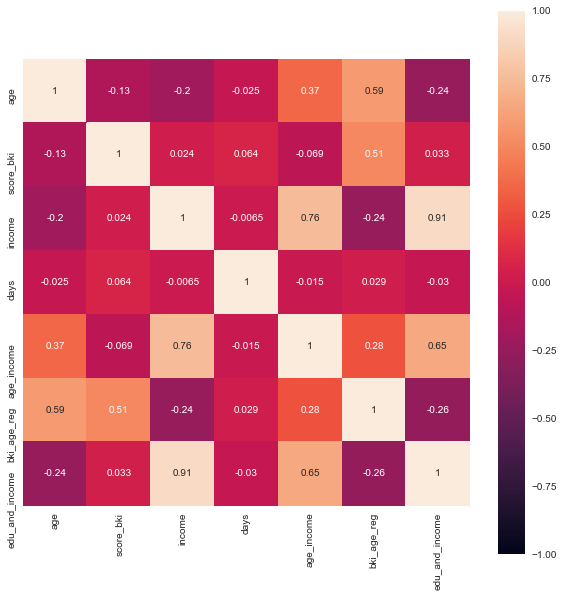

In [132]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(train[num_cols].corr(), vmin=-1, vmax=1, annot=True, ax=ax, square=True)
plt.show()

Высокой корреляции между исходными признаками не наблюдается, кроме созданного age_income. Пока оставим его в датасете

#### Создадим полиноминальные признаки

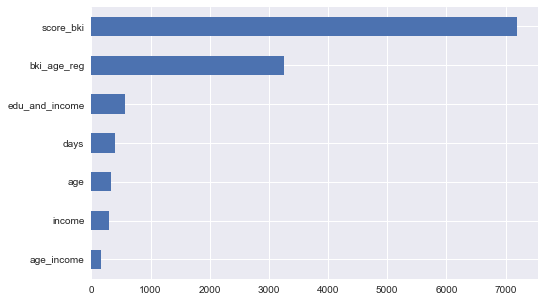

In [133]:
imp_num = Series(f_classif(train[num_cols], train['default'])[0], index = num_cols)
imp_num = imp_num.sort_values()
imp_num.plot(kind = 'barh')
plt.show()

In [134]:
# добавим новые полиномиальные признаки, 
# которые являются мат. комбинациями числовых признаков

pf = PolynomialFeatures(2, include_bias=False)
poly_data = pf.fit_transform(train[num_cols])[:, len(num_cols):]
poly_cols = pf.get_feature_names()[len(num_cols):]
poly_df = pd.DataFrame(poly_data, columns=poly_cols)
train = train.join(poly_df,  how='left')

poly_data = pf.transform(test[num_cols])[:, len(num_cols):]
poly_cols = pf.get_feature_names()[len(num_cols):]
poly_df = pd.DataFrame(poly_data, columns=poly_cols)
test = test.join(poly_df,  how='left')
num_cols = num_cols + poly_cols

In [135]:
corr_matrix = train[num_cols].corr()

In [136]:
for col in poly_cols:
    if len(corr_matrix[abs(corr_matrix[col]) > 0.8]) > 1:
        train.drop(col, inplace = True, axis = 1)
        test.drop(col, inplace = True, axis = 1)
        num_cols.remove(col)

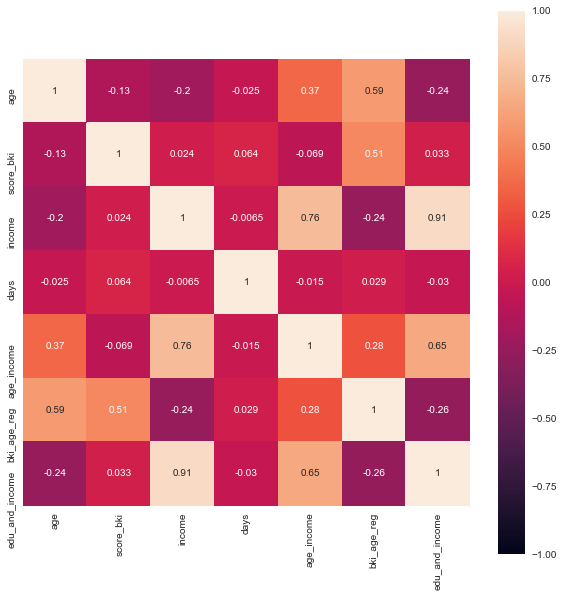

In [137]:
fig, ax = plt.subplots(figsize=(10, 10)) 
sns.heatmap(train[num_cols].corr(), vmin=-1, vmax=1, annot=True, ax=ax, square=True)
plt.show()

Значительная часть полиноминальных признаков была исключена - все они были сильно скоррелированы с каким-либо основными признаком

### Тест на значимость категориальных переменных

Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn. 

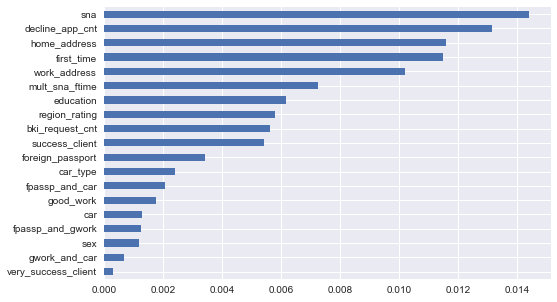

In [138]:
imp_cat = Series(mutual_info_classif(train[bin_cols + cat_cols], train['default'],
                                     discrete_features=True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')
plt.show()

*Как мы видим, самой значимой из значимости категориальных и бинарных переменных является sna*

### Подготовка данных к машинному обучению

Перед обучением регрессии нам следует стандартизировать числовые признаки, а также воспользоваться dummy-кодированием для категориальных переменных

In [139]:
#Воспользуемся методом One-Hot Encoding для преобразования категориальных переменных

ohe = OneHotEncoder(sparse = False)
X_cat = ohe.fit_transform(train[cat_cols].values)
Y_cat = ohe.transform(test[cat_cols].values)

In [140]:
# Стандартизация числовых переменных

ss = StandardScaler()
X_num = ss.fit_transform(train[num_cols].values)
Y_num = ss.transform(test[num_cols].values)

И объединим стандартизованные числовые, бинарные и закодированные категориальные переменные в одно признаковое пространство, разделив при этом признаки и целевую переменную

In [141]:
X = np.hstack([X_num, train[bin_cols].values, X_cat])
Y = train['default'].values

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=RANDOM_SEED)

### РЕГУЛЯРИЗАЦИЯ

Давайте найдем оптимальное значение параметра регуляризации для логистической регрессии.

In [143]:
max_iter = 1000
model = LogisticRegression(random_state=RANDOM_SEED).fit(X_train, y_train)

# Создадим гиперпараметры

# C = np.logspace(0, 4, 10)
# param_grid = [
#     {'penalty': ['l1'], 
#      'C': C,
#      'solver': ['liblinear  ', 'lbfgs'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[max_iter]},
#     {'penalty': ['l2'], 
#      'C': C,
#      'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[max_iter]},
#     {'penalty': ['none'], 
#      'C': C,
#      'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
#      'class_weight':['none', 'balanced'], 
#      'multi_class': ['auto','ovr'], 
#      'max_iter':[max_iter]},
# ]

penalty = ['l1', 'l2']
C = np.logspace(0, 4, 10)
#class_weight = ['balanced']
#param_grid = dict(C=C, penalty=penalty, class_weight=class_weight)
param_grid = dict(C=C, penalty=penalty)

grd = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1, cv=5)
best_model = grd.fit(X_train, y_train)
print('C:',best_model.best_estimator_.get_params()['C'])
print('Penalty:',best_model.best_estimator_.get_params()['penalty'])
print('Solver:',best_model.best_estimator_.get_params()['solver'])
print('Class_weight:',best_model.best_estimator_.get_params()['class_weight'])
print('Multi_class:',best_model.best_estimator_.get_params()['multi_class'])

C: 7.742636826811269
Penalty: l2
Solver: lbfgs
Class_weight: None
Multi_class: auto


Вариант с большим словарем гиперпараметров был проверен, но он не делал существенных превышений показаний, но значительно снижал производительность.
Зафиксированные при нем показатели.

C: 21.544346900318832
Penalty: l2
Solver: newton-cg
Class_weight: none
Multi_class: auto

Второй вариант
C: 7.742636826811269
Penalty: l2
Solver: lbfgs
Class_weight: None
Multi_class: auto

### Обучение и метрики

In [144]:
# Обучим модель

model = LogisticRegression(penalty=best_model.best_estimator_.get_params()['penalty'],
                           C=best_model.best_estimator_.get_params()['C'],
                           class_weight=best_model.best_estimator_.get_params()['class_weight'],
                           solver=best_model.best_estimator_.get_params()['solver'],
                           multi_class=best_model.best_estimator_.get_params()['multi_class'],
                           max_iter=max_iter,
                           random_state=RANDOM_SEED)
model.fit(X_train, y_train)

LogisticRegression(C=7.742636826811269, max_iter=1000, random_state=42)

In [145]:
model.get_params()

{'C': 7.742636826811269,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

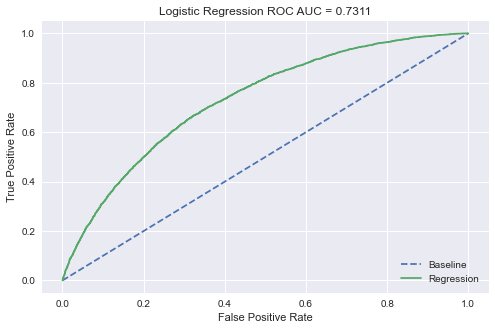

In [146]:
Y_predicted = model.predict(X_test)
probs = model.predict_proba(X_test)[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.4f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [147]:
def print_log_metrics(y_valid, y_pred, y_pred_prob):

    print('Accuracy: %.4f' % accuracy_score(y_valid, y_pred))
    print('Precision: %.4f' % precision_score(y_valid, y_pred))
    print('Recall: %.4f' % recall_score(y_valid, y_pred))
    print('F1: %.4f' % f1_score(y_valid, y_pred))

    precision, recall, thresholds = precision_recall_curve(y_valid, y_pred_prob)
    print('ROC_AUC = ', round(roc_auc_score(y_valid, y_pred_prob), 4))
    print('PRC_AUC = ', round(auc(recall, precision), 4))

In [148]:
print_log_metrics(y_test, Y_predicted, probs)

Accuracy: 0.6719
Precision: 0.6749
Recall: 0.7042
F1: 0.6893
ROC_AUC =  0.7311
PRC_AUC =  0.7192


Показатели модели при сильном словаре гиперпараметров

Accuracy: 0.6744
Precision: 0.6803
Recall: 0.7143
F1: 0.6969
ROC_AUC =  0.7357
PRC_AUC =  0.7334

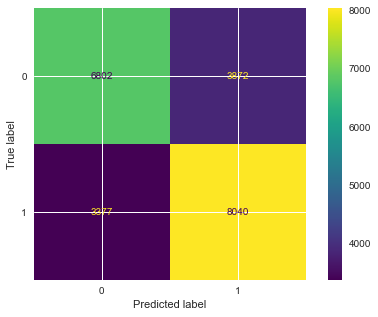

In [149]:
# confusion matrix
cm = confusion_matrix(y_test, Y_predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

#### Кросс-валидация

In [150]:
from sklearn.model_selection import cross_validate

cv_metrics = cross_validate(model, X_train, y_train, cv=5, scoring='f1', return_train_score=True)

In [151]:
def plot_cv_metrics(cv_metrics):
    
    avg_f1_train, std_f1_train = cv_metrics['train_score'].mean(), cv_metrics['train_score'].std()
    avg_f1_valid, std_f1_valid = cv_metrics['test_score'].mean(), cv_metrics['test_score'].std()
    print('[train] f1-score = {:.4f} +/- {:.4f}'.format(avg_f1_train, std_f1_train))
    print('[test] f1-score = {:.4f} +/- {:.4f}'.format(avg_f1_valid, std_f1_valid))
    plt.figure(figsize=(12, 4))

    plt.plot(cv_metrics['train_score'], label='train', marker='o')
    plt.plot(cv_metrics['test_score'], label='test', marker='x')

    plt.ylim([0., 1.]);
    plt.xlabel('iteration', fontsize=15)
    plt.ylabel('f1 score', fontsize=15)
    plt.legend(fontsize=15)
    plt.show()

[train] f1-score = 0.6847 +/- 0.0005
[test] f1-score = 0.6840 +/- 0.0020


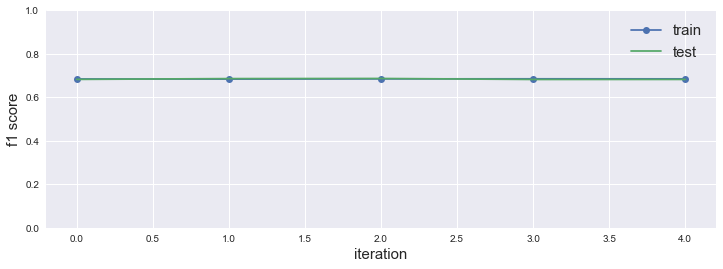

In [152]:
plot_cv_metrics(cv_metrics)

Переобученности или недообученности модели не наблюдается

#### Cоздаём экземпляр таблицы с предсказаниями, чтобы выложить его на kaggle

In [153]:
id_test = test['client_id']
X = np.hstack([Y_num, test[bin_cols].values, Y_cat])

In [154]:
probs = model.predict_proba(X)
probs = probs[:,1]

In [155]:
my_submission = pd.DataFrame({'client_id': id_test, 'default': probs})
my_submission.to_csv(file_path + 'submission.csv', index=False)
my_submission.head(5)

,client_id,default
0,74835,0.230279
1,17527,0.835602
2,75683,0.254018
3,26883,0.411602
4,28862,0.140732
